# Pothole Avoidance

### Google Doc File : https://docs.google.com/document/d/14BvO7FcM70Ti601LYFrhvsd2bOynnWx7zIw7ddQspVE/edit?usp=sharing

In [262]:
# from google.colab import drive
# drive.mount('/content/drive')

## Multiple Drivers at once

In [263]:
import os
import pandas as pd
import numpy as np

def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c * 1000  # convert to meters

    return distance

def process_log_line(line):
    if "Feedback Code Starting" in line:
        return None

    sections = line.split(' :- ')

    if len(sections) != 2:
        return None

    log_timestamp = sections[0].strip().split(',')[0]
    log_details = sections[1].strip()

    details_parts = log_details.split(':')
    log_seq = details_parts[0]
    data_dict = {'Log_seq': int(log_seq)}

    mabx_values = [item.strip() for item in details_parts[1:]]
    data_dict['Timestamp'] = log_timestamp
    seq, veh_speed, tire_angle = map(float, mabx_values[0].split('||')[0].split(','))

    data_dict['MABX_seq'] = int(seq)
    data_dict['Veh_MABX_Speed'] = veh_speed
    data_dict['Tire_Angle'] = tire_angle

    # unix_time = mabx_values[0].split('||')[1].strip().split(',')[0]
    
    gnss_values = mabx_values[0].split('||')[1].strip().split(',')
    if len(gnss_values) == 10:
        unixtime, lat, lng, lat_std, lng_std, gnss_speed, acc, roll, pitch, heading = map(float, gnss_values)
        data_dict['Unixtime'] = int(unixtime)
        data_dict['Lat'] = lat
        data_dict['Lng'] = lng
        data_dict['Lat_std'] = lat_std
        data_dict['Lng_std'] = lng_std
        data_dict['Veh_GNSS_Speed'] = gnss_speed
        data_dict['Z_Acc'] = acc
        data_dict['Roll'] = roll
        data_dict['Pitch'] = pitch
        data_dict['Heading'] = heading
    else:
        # print(f"Skipping line due to unexpected number of values: {len(gnss_values)} in line: {line}")
        return None

    return data_dict

def read_and_process_log_file(file_path, dataframe):
    with open(file_path, 'r') as file:
        file_content = file.read()

    file_lines = file_content.split('\n')

    data_list = []

    for line in file_lines:
        data_dict = process_log_line(line)
        if data_dict is not None:
            data_list.append(data_dict)

    if data_list:
        dataframe = pd.concat([dataframe, pd.DataFrame(data_list)], ignore_index=True)

    return dataframe

data = {}

# extract all the folders in the directory

# Specify the directory path
directory_path = '/Users/ravitejakunchanapalli/Downloads/A2pothole-data 3'

items = os.listdir(directory_path)
items.sort()
folder_paths = [os.path.join(directory_path, item) for item in items if os.path.isdir(os.path.join(directory_path, item))]

# Specify the list of folder paths containing log files
# folder_paths = [
#                 'pothole-data/Abhisek',
#                 'pothole-data/Aravind',
#                 'pothole-data/Rahul',
#                 'pothole-data/Santhosh',
#                 'pothole-data/Nithish',
#                 'pothole-data/Sai',
#                 'pothole-data/Jaisingh/',
#                 'pothole-data/Mahipal',
#                 'pothole-data/Shyam',
#                 'pothole-data/Rishav',
#                 # 'pothole-data/Vijay',
#                 'pothole-data/ANchary',
#                 'pothole-data/karthik',
#                 'pothole-data/praveen-pr',
#                 'pothole-data/r-rahul',
#                 'pothole-data/raghuvamsi',
#                 'pothole-data/rvijay',
#                 'pothole-data/samukha',
# ]
# Process log files in each folder path
for folder_path in folder_paths:
    folder_name = os.path.basename(os.path.normpath(folder_path))  # Get the last word of the path

    # Initialize DataFrames for each type
    auto10_df = pd.DataFrame()
    auto20_df = pd.DataFrame()
    auto30_df = pd.DataFrame()

    for filename in sorted(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith(".log") and os.path.isfile(file_path):
            if 'cone10' in filename:
                auto10_df = read_and_process_log_file(file_path, auto10_df)
                auto10_df['dist_from_start'] = haversine_vectorized(auto10_df['Lat'][0], auto10_df['Lng'][0], auto10_df['Lat'], auto10_df['Lng'])
            elif 'cone20' in filename:
                auto20_df = read_and_process_log_file(file_path, auto20_df)
                auto20_df['dist_from_start'] = haversine_vectorized(auto20_df['Lat'][0], auto20_df['Lng'][0], auto20_df['Lat'], auto20_df['Lng'])
            elif 'cone30' in filename:
                auto30_df = read_and_process_log_file(file_path, auto30_df)
                auto30_df['dist_from_start'] = haversine_vectorized(auto30_df['Lat'][0], auto30_df['Lng'][0], auto30_df['Lat'], auto30_df['Lng'])

    # Add the DataFrames to the main data dictionary using the folder name as the key
    data[folder_name] = {
        'cone10': auto10_df.copy(),
        'cone20': auto20_df.copy(),
        'cone30': auto30_df.copy(),
    }

    # Confirm that the dataframes are not empty
    for key, value in data[folder_name].items():
        if value.empty:
            print(f"Empty DataFrame for {folder_name} - {key}")


### Some Information about the dataframe

In [264]:
data['Rishav']['cone20'].head()

,Log_seq,Timestamp,MABX_seq,Veh_MABX_Speed,Tire_Angle,Unixtime,Lat,Lng,Lat_std,Lng_std,Veh_GNSS_Speed,Z_Acc,Roll,Pitch,Heading,dist_from_start
0,2,2024-01-24 11:51:39,61,20.0,-0.1,1706077299,17.601754,78.126609,0.01,0.01,25.29,9.62,0.95,-0.40,359.09,0.000000
1,3,2024-01-24 11:51:39,64,20.0,-0.1,1706077299,17.601754,78.126609,0.01,0.01,25.29,10.02,0.97,-0.41,359.10,0.000000
2,4,2024-01-24 11:51:39,67,20.0,-0.1,1706077299,17.601754,78.126609,0.01,0.01,25.18,9.92,0.98,-0.40,359.11,0.000000
3,5,2024-01-24 11:51:39,70,20.0,-0.1,1706077299,17.601760,78.126609,0.01,0.01,25.18,10.17,1.00,-0.40,359.12,0.702748
4,6,2024-01-24 11:51:39,73,20.0,-0.1,1706077299,17.601760,78.126609,0.01,0.01,25.18,10.01,1.02,-0.39,359.13,0.702748


In [265]:
data['Rishav']['cone20'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Log_seq          455 non-null    int64  
 1   Timestamp        455 non-null    object 
 2   MABX_seq         455 non-null    int64  
 3   Veh_MABX_Speed   455 non-null    float64
 4   Tire_Angle       455 non-null    float64
 5   Unixtime         455 non-null    int64  
 6   Lat              455 non-null    float64
 7   Lng              455 non-null    float64
 8   Lat_std          455 non-null    float64
 9   Lng_std          455 non-null    float64
 10  Veh_GNSS_Speed   455 non-null    float64
 11  Z_Acc            455 non-null    float64
 12  Roll             455 non-null    float64
 13  Pitch            455 non-null    float64
 14  Heading          455 non-null    float64
 15  dist_from_start  455 non-null    float64
dtypes: float64(12), int64(3), object(1)
memory usage: 57.0+ KB


In [266]:
data['Rishav']['cone30'].describe()

,Log_seq,MABX_seq,Veh_MABX_Speed,Tire_Angle,Unixtime,Lat,Lng,Lat_std,Lng_std,Veh_GNSS_Speed,Z_Acc,Roll,Pitch,Heading,dist_from_start
count,499.000000,499.000000,499.000000,499.000000,4.990000e+02,499.000000,499.000000,4.990000e+02,4.990000e+02,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000
mean,257.178357,128.677355,21.903006,-0.017435,1.706077e+09,17.602104,78.126600,1.000000e-02,1.000000e-02,21.970160,9.797074,1.158758,-0.271042,259.113747,49.756388
std,147.555375,73.346910,5.123955,3.180601,4.406935e+00,0.000226,0.000008,1.250254e-16,1.250254e-16,4.673483,0.372016,0.554069,0.276455,156.998922,25.134960
min,2.000000,1.000000,15.700000,-10.100000,1.706077e+09,17.601657,78.126580,1.000000e-02,1.000000e-02,15.860000,6.700000,-0.710000,-0.730000,0.010000,0.000000
25%,129.500000,66.000000,17.500000,-0.200000,1.706077e+09,17.601935,78.126597,1.000000e-02,1.000000e-02,17.850000,9.610000,0.925000,-0.480000,13.170000,30.923757
50%,258.000000,130.000000,20.200000,0.100000,1.706077e+09,17.602128,78.126602,1.000000e-02,1.000000e-02,20.630000,9.790000,1.180000,-0.330000,357.820000,52.507363
75%,384.500000,193.000000,26.700000,1.500000,1.706077e+09,17.602282,78.126606,1.000000e-02,1.000000e-02,26.710000,9.980000,1.540000,-0.140000,358.900000,69.533472
max,512.000000,254.000000,30.000000,4.200000,1.706077e+09,17.602491,78.126610,1.000000e-02,1.000000e-02,30.580000,11.830000,2.270000,0.590000,359.960000,92.739077


#### Exact Coordinates of Pothole

In [267]:
# Given data
coordinates = [
    [17.60212920034102,78.12660001252421],
[17.602129205336254,78.1266000542438],
[17.60212921184398,78.12660005133608],
[17.602129213015047,78.1265999961345],
[17.60212921295533,78.12659998326836],
[17.602129197994497,78.12659998115265],
[17.602129195145196,78.12659998318172],
[17.60212919067419,78.12660000452459],
[17.602129188389295,78.12660000922517],
[17.602129191403506,78.12660000529944],
[17.602129196021263,78.12659999920172],
[17.602129214420856,78.12659999764647],
[17.602129212119863,78.12660000299401],
[17.602129225311288,78.12660002454331],
[17.602129224460686,78.12660002807299],
[17.602129204381544,78.12660001001785],
[17.60212920944943,78.12660001111456],
[17.602129209057633,78.12660001736165],
[17.6021292038509,78.12660000433704],
[17.602129195525006,78.12660001294643],
[17.602129197239716,78.12660001561063],
[17.60212922970704,78.12659999643618],
[17.602129201367628,78.12660004648555],
[17.602129183615848,78.12660007331219],
[17.602129172863943,78.12660006778376],
[17.602129180239363,78.12660007376188],
[17.602129186204376,78.12660005962182],
[17.6021291983505,78.12660007223636],
[17.602129210014883,78.12660007212428],
[17.6021292080456,78.12660007746132],
[17.60212920379557,78.12660006787422],
[17.60212918556187,78.12660007254686],
[17.60212918626751,78.12660006483189],
[17.602129189863582,78.12660009322515],
[17.60212921206086,78.12660009153359],
[17.60212920481641,78.12660007864112],
[17.602129206941893,78.12660007402059],
[17.60212920892319,78.1266000738626],
[17.602129201111843,78.12660006533673],
[17.602129194501785,78.12660007205551],
[17.60212919672022,78.12660005749125],
[17.602129177276108,78.12660005612301],
[17.602129172489658,78.12660005783228],
[17.60212918158953,78.12660006182901],
[17.602129184271117,78.12660006565336],
[17.602129179038315,78.12660005447668],
[17.6021291746903,78.12660006002532],
[17.602129204677436,78.12660006387442],
[17.60212920428487,78.12660006662738],
[17.602129215701492,78.12660008811991],
[17.602129197179732,78.12660009657849],
[17.602129198351324,78.12660008244548],
[17.60212918178512,78.12660007756497],
[17.602129209129384,78.12660006565271],
[17.60212920865285,78.1266000697043],
[17.602129203783246,78.12660008263042],
[17.602129209018898,78.12660007872105],
[17.602129220558947,78.12660005807533],
[17.60212922140273,78.12660005080151],
[17.60212919791577,78.12660006096857],
[17.602129193512788,78.1266000606137],
[17.602129212063797,78.12660007757702],
[17.60212920905661,78.12660006272448],
[17.602129217343357,78.12660006681978],
[17.602129221634783,78.12660004479164],
[17.602129226996848,78.1266000424961],
[17.60212922637783,78.12660005462764],
[17.602129220189187,78.12660005377109],
[17.602129225167754,78.1266000581164],
[17.602129210748743,78.12660007183574],
[17.602129209189965,78.12660005338648],
[17.602129206322207,78.12660006695955],
[17.60212921293849,78.12660006982303],
[17.60212919595281,78.1266000365929],
[17.602129204334304,78.12660002860542],
[17.602129223536508,78.12660000317324],
[17.602129248664497,78.12659995945907],
[17.602129190310787,78.12660008611236],
[17.6021291879835,78.1266000825448],
[17.602129222718453,78.12660001943942],
[17.602129230140402,78.12660002289694],
[17.602129222547237,78.12660001912677],
[17.60212922115728,78.12660001796384],
]

# Extract latitude and longitude separately
latitudes = [coord[0] for coord in coordinates]
longitudes = [coord[1] for coord in coordinates]

# Calculate mean latitude and longitude
mean_latitude = sum(latitudes) / len(latitudes)
mean_longitude = sum(longitudes) / len(longitudes)

print("Mean Latitude/Longitude of pothole:", mean_latitude, mean_longitude)


Mean Latitude/Longitude of pothole: 17.602129204103562 78.12660004713902


### Starting and Ending Point 

In [268]:
# Find the ending point closest to given lat, long
ending_point = {}
given_lat, given_lon = 17.602129204103562,78.12660004713902

for user_name, user_data in data.items():
    ending_point[user_name] = {}
    for df_name, df in user_data.items():
        df['dist_to_pothole'] = df.apply(lambda row: haversine_vectorized(row['Lat'], row['Lng'], given_lat, given_lon), axis=1)
        closest_idx = df['dist_to_pothole'].idxmin()
        ending_point[user_name][df_name] = closest_idx


# Find the starting point at distance after 25 meter and absolute value of tire angle greater than 2 degree
starting_point = {}

for user_name, user_data in data.items():
    starting_point[user_name] = {}
    for df_name, df in user_data.items():
        indices_for_start = df[(df['dist_to_pothole'] < 40) & (df['Tire_Angle'].abs() > 1)].index
        if not indices_for_start.empty:
            starting_point[user_name][df_name] = indices_for_start[0]
        else:
            starting_point[user_name][df_name] = None



# Initialize a dictionary to store the index of the highest tire_angle for each ending point
highest_tire_angle_index = {}

for user_name, user_data in data.items():
    highest_tire_angle_index[user_name] = {}
    for df_name, df in user_data.items():
        # Get the index of the ending point
        ending_idx = ending_point[user_name][df_name]
        # Define the range of indices to consider around the ending point
        start_idx = max(0, ending_idx - 50)
        end_idx = min(len(df) - 1, ending_idx + 100)
        # Get the subset of the dataframe within this range
        df_subset = df.iloc[start_idx:end_idx + 1]
        # Find the index of the highest absolute tire_angle within this subset
        highest_tire_angle_idx = df_subset['Tire_Angle'].abs().idxmax()
        highest_tire_angle_index[user_name][df_name] = highest_tire_angle_idx


print(starting_point)
# print(ending_point)
print(highest_tire_angle_index)

ending_point = highest_tire_angle_index


{'Nithish': {'cone10': 387, 'cone20': 414, 'cone30': 141}, 'Rishav': {'cone10': 391, 'cone20': 118, 'cone30': 139}, 'karthik': {'cone10': 522, 'cone20': 136, 'cone30': 128}, 'kritika': {'cone10': 455, 'cone20': 169, 'cone30': 127}, 'nithish-mtech': {'cone10': 410, 'cone20': 179, 'cone30': 39}, 'praveen-pr': {'cone10': 449, 'cone20': 170, 'cone30': 122}, 'rvijay': {'cone10': 528, 'cone20': 185, 'cone30': 137}, 'sandeep': {'cone10': 447, 'cone20': 163, 'cone30': 133}}
{'Nithish': {'cone10': 540, 'cone20': 551, 'cone30': 232}, 'Rishav': {'cone10': 486, 'cone20': 213, 'cone30': 240}, 'karthik': {'cone10': 781, 'cone20': 273, 'cone30': 153}, 'kritika': {'cone10': 742, 'cone20': 273, 'cone30': 224}, 'nithish-mtech': {'cone10': 592, 'cone20': 377, 'cone30': 122}, 'praveen-pr': {'cone10': 573, 'cone20': 247, 'cone30': 200}, 'rvijay': {'cone10': 650, 'cone20': 268, 'cone30': 232}, 'sandeep': {'cone10': 589, 'cone20': 269, 'cone30': 245}}


paramteres for Driving experience
Expert : 
Novice :
Intermiediate :

In [269]:
# data['ANchary']['cone10'].iloc[starting_point['ANchary']['cone10']]
data['Rishav']['cone10'].iloc[ending_point['Rishav']['cone10']]

Log_seq                            496
Timestamp          2024-01-24 11:48:53
MABX_seq                           166
Veh_MABX_Speed                    21.9
Tire_Angle                        -8.6
Unixtime                    1706077133
Lat                          17.602112
Lng                          78.126587
Lat_std                           0.01
Lng_std                           0.01
Veh_GNSS_Speed                   22.29
Z_Acc                             9.93
Roll                              -0.7
Pitch                            -0.52
Heading                         356.58
dist_from_start              47.519246
dist_to_pothole               2.337782
Name: 486, dtype: object

#### Plot for all users

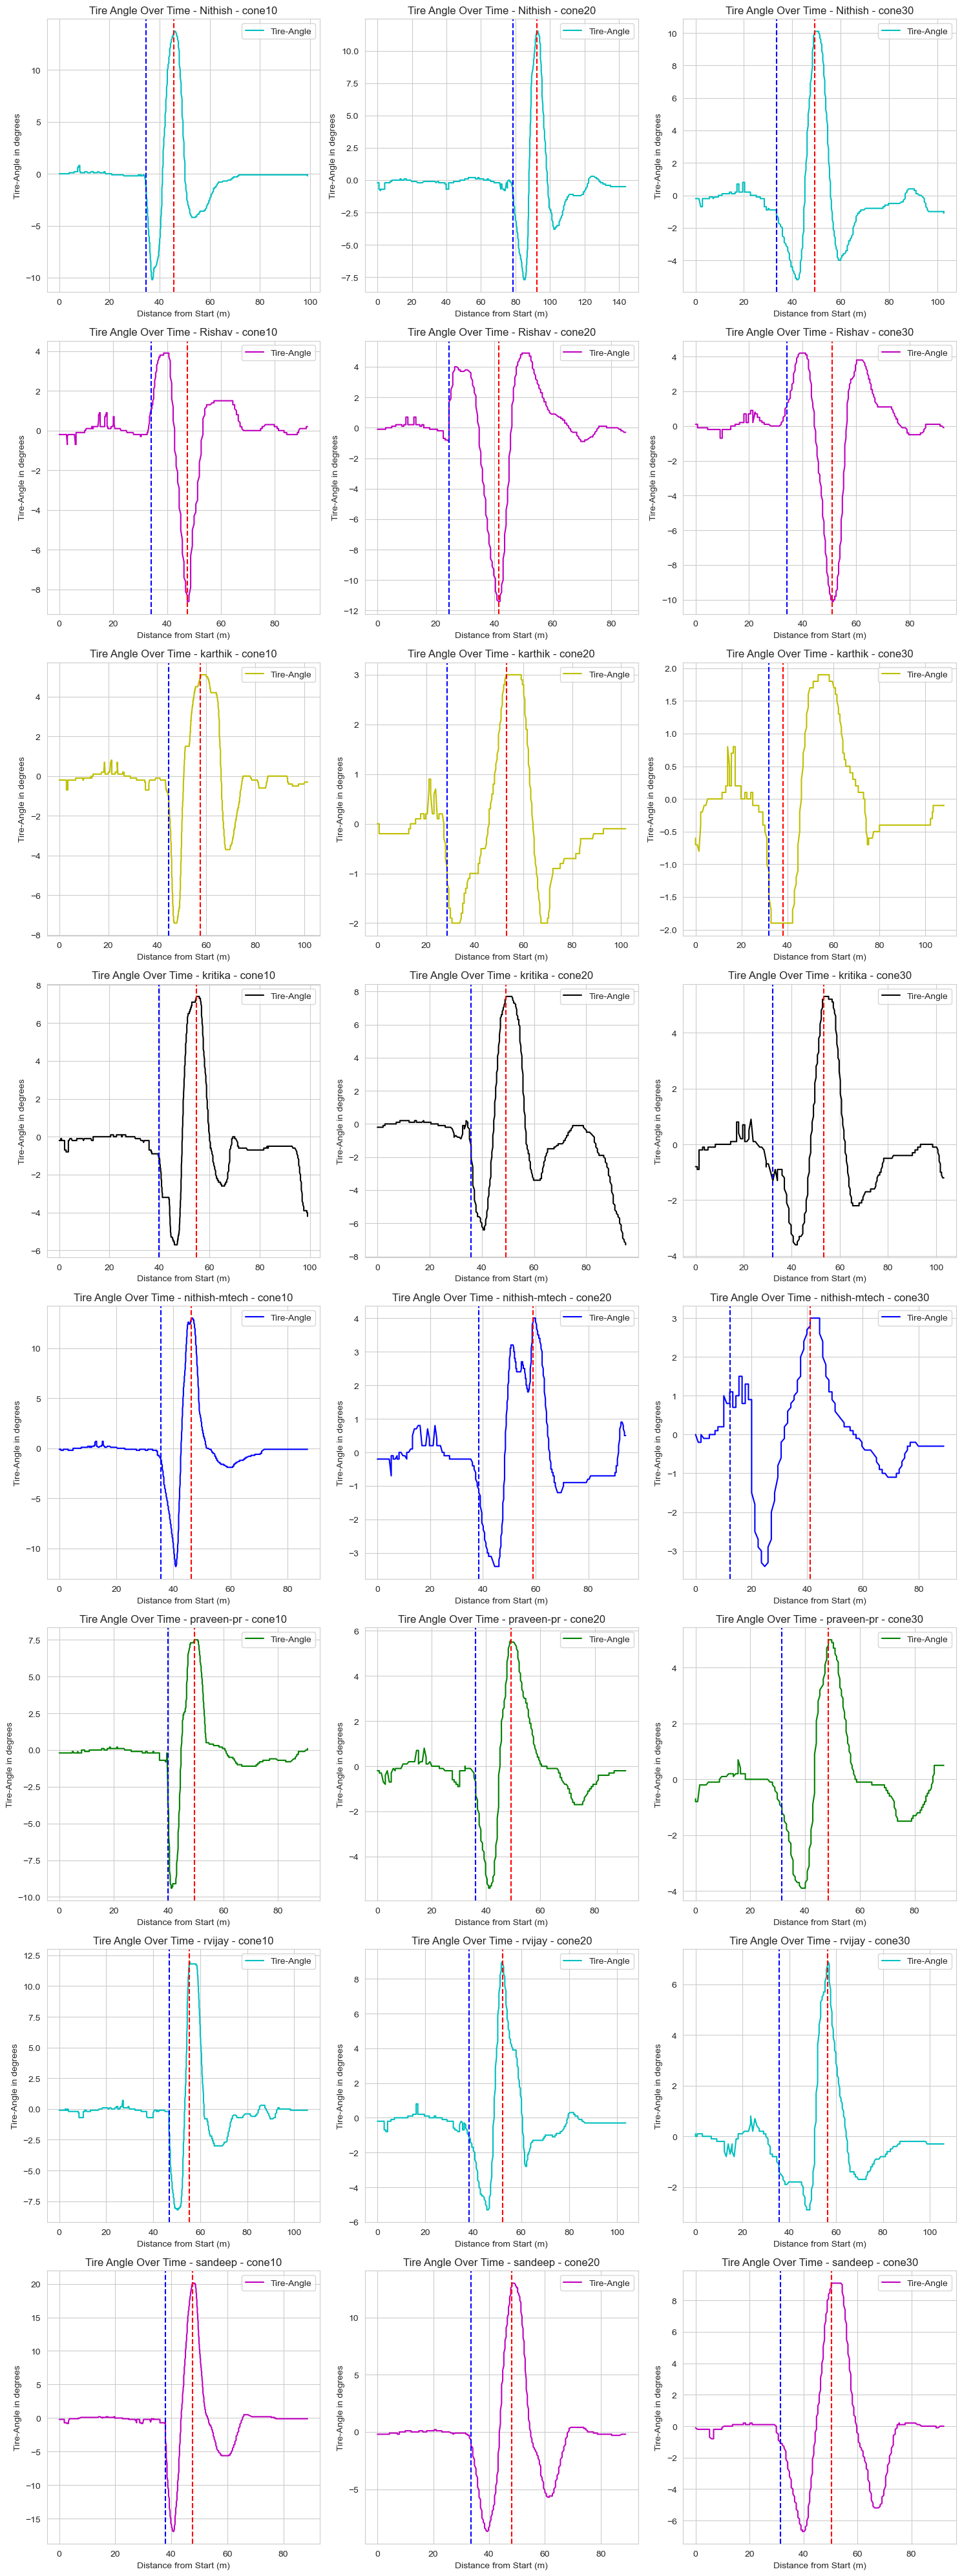

In [270]:
import matplotlib.pyplot as plt

# Determine the number of users and datasets
num_users = len(data)
num_datasets = len(next(iter(data.values())))

# Flatten the 2D array of subplots into a 1D array
fig, axs = plt.subplots(num_users, num_datasets, figsize=(15, 5*num_users))
axs_flat = axs.flatten()

# Define a list of colors
colors = ['b', 'g', 'c', 'm', 'y', 'k']

for j, (user_name, user_data) in enumerate(data.items()):
    for i, (df_name, df) in enumerate(user_data.items()):
        axs_flat[j * num_datasets + i].plot(df['dist_from_start'], df['Tire_Angle'], label=f'Tire-Angle', color=colors[(j + 2) % len(colors)])

        axs_flat[j * num_datasets + i].set_xlabel('Distance from Start (m)')
        axs_flat[j * num_datasets + i].set_ylabel('Tire-Angle in degrees')
        axs_flat[j * num_datasets + i].set_title(f'Tire Angle Over Time - {user_name} - {df_name}')
        axs_flat[j * num_datasets + i].grid(True)
        axs_flat[j * num_datasets + i].legend()
        
        # Find the 'dist_from_start' value for the ending point
        ending_dist_from_start = df.loc[ending_point[user_name][df_name], 'dist_from_start']
        #plot the line for starting point
        starting_point_line = df.loc[starting_point[user_name][df_name], 'dist_from_start']
        
        axs_flat[j * num_datasets + i].axvline(x=starting_point_line, color='b', linestyle='--')
        axs_flat[j * num_datasets + i].axvline(x=ending_dist_from_start, color='r', linestyle='--')

plt.tight_layout()
plt.show()

### For Reaction Time and Distance

##### For all users Reaction distance 

In [271]:
reaction_distance = {}

for user_name, user_data in data.items():
    reaction_distance[user_name] = {}
    for df_name, df in user_data.items():
        if starting_point[user_name][df_name] is not None and ending_point[user_name][df_name] is not None:
            reaction_distance[user_name][df_name] = data[user_name][df_name].iloc[ending_point[user_name][df_name]]['dist_from_start'] - data[user_name][df_name].iloc[starting_point[user_name][df_name]]['dist_from_start']
        else:
            reaction_distance[user_name][df_name] = None
    
reaction_distance


{'Nithish': {'cone10': 11.019394672587616,
  'cone20': 13.871671064701644,
  'cone30': 15.765771632145956},
 'Rishav': {'cone10': 13.454263193984744,
  'cone20': 16.940872398835324,
  'cone30': 16.92469682415203},
 'karthik': {'cone10': 12.797806239017447,
  'cone20': 24.259548719232207,
  'cone30': 6.166932786839066},
 'kritika': {'cone10': 15.074454388781888,
  'cone20': 13.353982548022003,
  'cone30': 21.15988947304792},
 'nithish-mtech': {'cone10': 10.832594980290231,
  'cone20': 20.676128301189465,
  'cone30': 28.844454997403098},
 'praveen-pr': {'cone10': 9.697677554765782,
  'cone20': 12.993644924869528,
  'cone30': 16.96771936580806},
 'rvijay': {'cone10': 8.76401806949869,
  'cone20': 14.038481601376816,
  'cone30': 20.91939005112563},
 'sandeep': {'cone10': 9.729143237013915,
  'cone20': 14.63995639967441,
  'cone30': 18.88627955939983}}

In [272]:
reaction_distance_mean = {}

# Iterate over each DataFrame (df_name)
for df_name in data['Rishav'].keys():
    reaction_distance_mean[df_name] = {}
    
    # Iterate over each user
    for user_name, user_data in data.items():
        if starting_point[user_name][df_name] is not None and ending_point[user_name][df_name] is not None:
            reaction_distance_mean[df_name][user_name] = data[user_name][df_name].iloc[ending_point[user_name][df_name]]['dist_from_start'] - data[user_name][df_name].iloc[starting_point[user_name][df_name]]['dist_from_start']
        else:
            reaction_distance_mean[df_name][user_name] = None

# Convert the nested dictionary to a DataFrame for easier mean calculation
reaction_distance_df = pd.DataFrame(reaction_distance_mean)

# Calculate the mean for each DataFrame
reaction_distance = reaction_distance_df.mean(axis=0).to_dict()

print(reaction_distance)


{'cone10': 11.421169041992538, 'cone20': 16.346785744737677, 'cone30': 18.204391836240198}


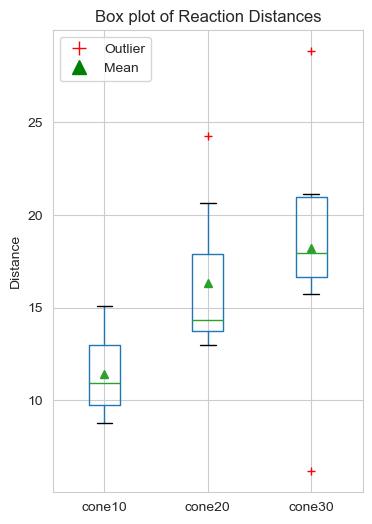

In [273]:
# Draw a box plot of the DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

plt.figure(figsize=(4, 6))  # Adjust the size as needed
reaction_distance_df.boxplot(sym='r+', showmeans= True)
plt.title('Box plot of Reaction Distances')
plt.ylabel('Distance')
plt.xticks() 
outlier_line = mlines.Line2D([], [], color='red', marker='+', linestyle='None', markersize=10, label='Outlier')
mean_line = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Mean')

plt.legend(handles=[outlier_line, mean_line]) # Rotate x-axis labels for better visibility if needed
plt.show()

#### For all users Reaction time

In [274]:
reaction_time = {}

for user_name, user_data in data.items():
    reaction_time[user_name] = {}
    for df_name, df in user_data.items():
        if starting_point[user_name][df_name] is not None and ending_point[user_name][df_name] is not None:
            reaction_time[user_name][df_name] = data[user_name][df_name].iloc[ending_point[user_name][df_name]]['Unixtime'] - data[user_name][df_name].iloc[starting_point[user_name][df_name]]['Unixtime']
        else:
            reaction_time[user_name][df_name] = None
    
reaction_time

{'Nithish': {'cone10': 4, 'cone20': 4, 'cone30': 2},
 'Rishav': {'cone10': 3, 'cone20': 3, 'cone30': 3},
 'karthik': {'cone10': 8, 'cone20': 4, 'cone30': 1},
 'kritika': {'cone10': 9, 'cone20': 3, 'cone30': 3},
 'nithish-mtech': {'cone10': 5, 'cone20': 6, 'cone30': 2},
 'praveen-pr': {'cone10': 3, 'cone20': 2, 'cone30': 2},
 'rvijay': {'cone10': 3, 'cone20': 2, 'cone30': 3},
 'sandeep': {'cone10': 4, 'cone20': 3, 'cone30': 3}}

In [275]:
reaction_time_mean = {}

# Iterate over each DataFrame (df_name)
for df_name in data['Rishav'].keys():
    reaction_time_mean[df_name] = {}
    
    # Iterate over each user
    for user_name, user_data in data.items():
        if starting_point[user_name][df_name] is not None and ending_point[user_name][df_name] is not None:
            reaction_time_mean[df_name][user_name] = data[user_name][df_name].iloc[ending_point[user_name][df_name]]['Unixtime'] - data[user_name][df_name].iloc[starting_point[user_name][df_name]]['Unixtime']
        else:
            reaction_time_mean[df_name][user_name] = None

# Convert the nested dictionary to a DataFrame for easier mean calculation
reaction_time_df = pd.DataFrame(reaction_time_mean)

# Calculate the mean for each DataFrame
mean_time = reaction_time_df.mean(axis=0).to_dict()

print(mean_time)


{'cone10': 4.875, 'cone20': 3.375, 'cone30': 2.375}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


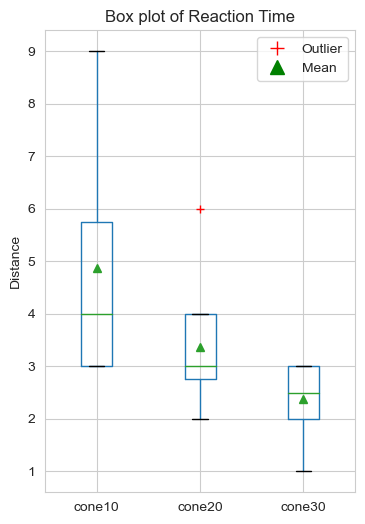

In [276]:
# Draw a box plot of the DataFrame
plt.figure(figsize=(4, 6))  # Adjust the size as needed
reaction_time_df.boxplot(sym='r+',showmeans= True)
plt.title('Box plot of Reaction Time')
plt.ylabel('Distance')
plt.legend()
plt.xticks()
outlier_line = mlines.Line2D([], [], color='red', marker='+', linestyle='None', markersize=10, label='Outlier')
mean_line = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Mean')

plt.legend(handles=[outlier_line, mean_line])  # Rotate x-axis labels for better visibility if needed
plt.show()

#### Average Speed at SpeedBreaker

In [277]:
#find average speed at endpoints
speeds = {}

# Iterate over each DataFrame (df_name)
for df_name in data['Rishav'].keys():
    speeds[df_name] = {}
    
    # Iterate over each user
    for user_name, user_data in data.items():
        if starting_point[user_name][df_name] is not None and ending_point[user_name][df_name] is not None:
            speeds[df_name][user_name] = data[user_name][df_name].iloc[ending_point[user_name][df_name]]['Veh_MABX_Speed']
        else:
            speeds[df_name][user_name] = None

# Convert the nested dictionary to a DataFrame for easier mean calculation
speed_df = pd.DataFrame(speeds)

# Calculate the mean for each DataFrame
mean_speed = speed_df.mean(axis=0).to_dict()

print(mean_speed)

{'cone10': 9.5125, 'cone20': 15.962499999999999, 'cone30': 22.6375}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


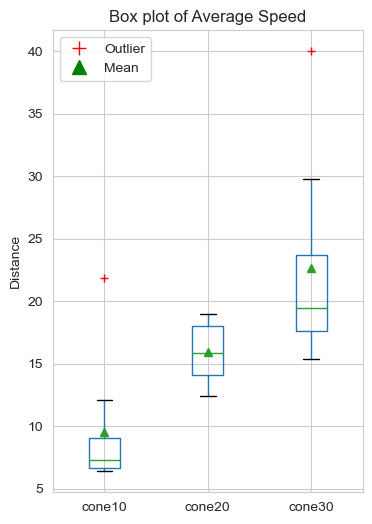

In [278]:
# Draw a box plot of the DataFrame
plt.figure(figsize=(4, 6))  # Adjust the size as needed
speed_df.boxplot(sym='r+',showmeans= True)
plt.title('Box plot of Average Speed')
plt.ylabel('Distance')
plt.legend()
plt.xticks() 
outlier_line = mlines.Line2D([], [], color='red', marker='+', linestyle='None', markersize=10, label='Outlier')
mean_line = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Mean')

plt.legend(handles=[outlier_line, mean_line]) # Rotate x-axis labels for better visibility if needed
plt.show()

## Alls users in each subplot

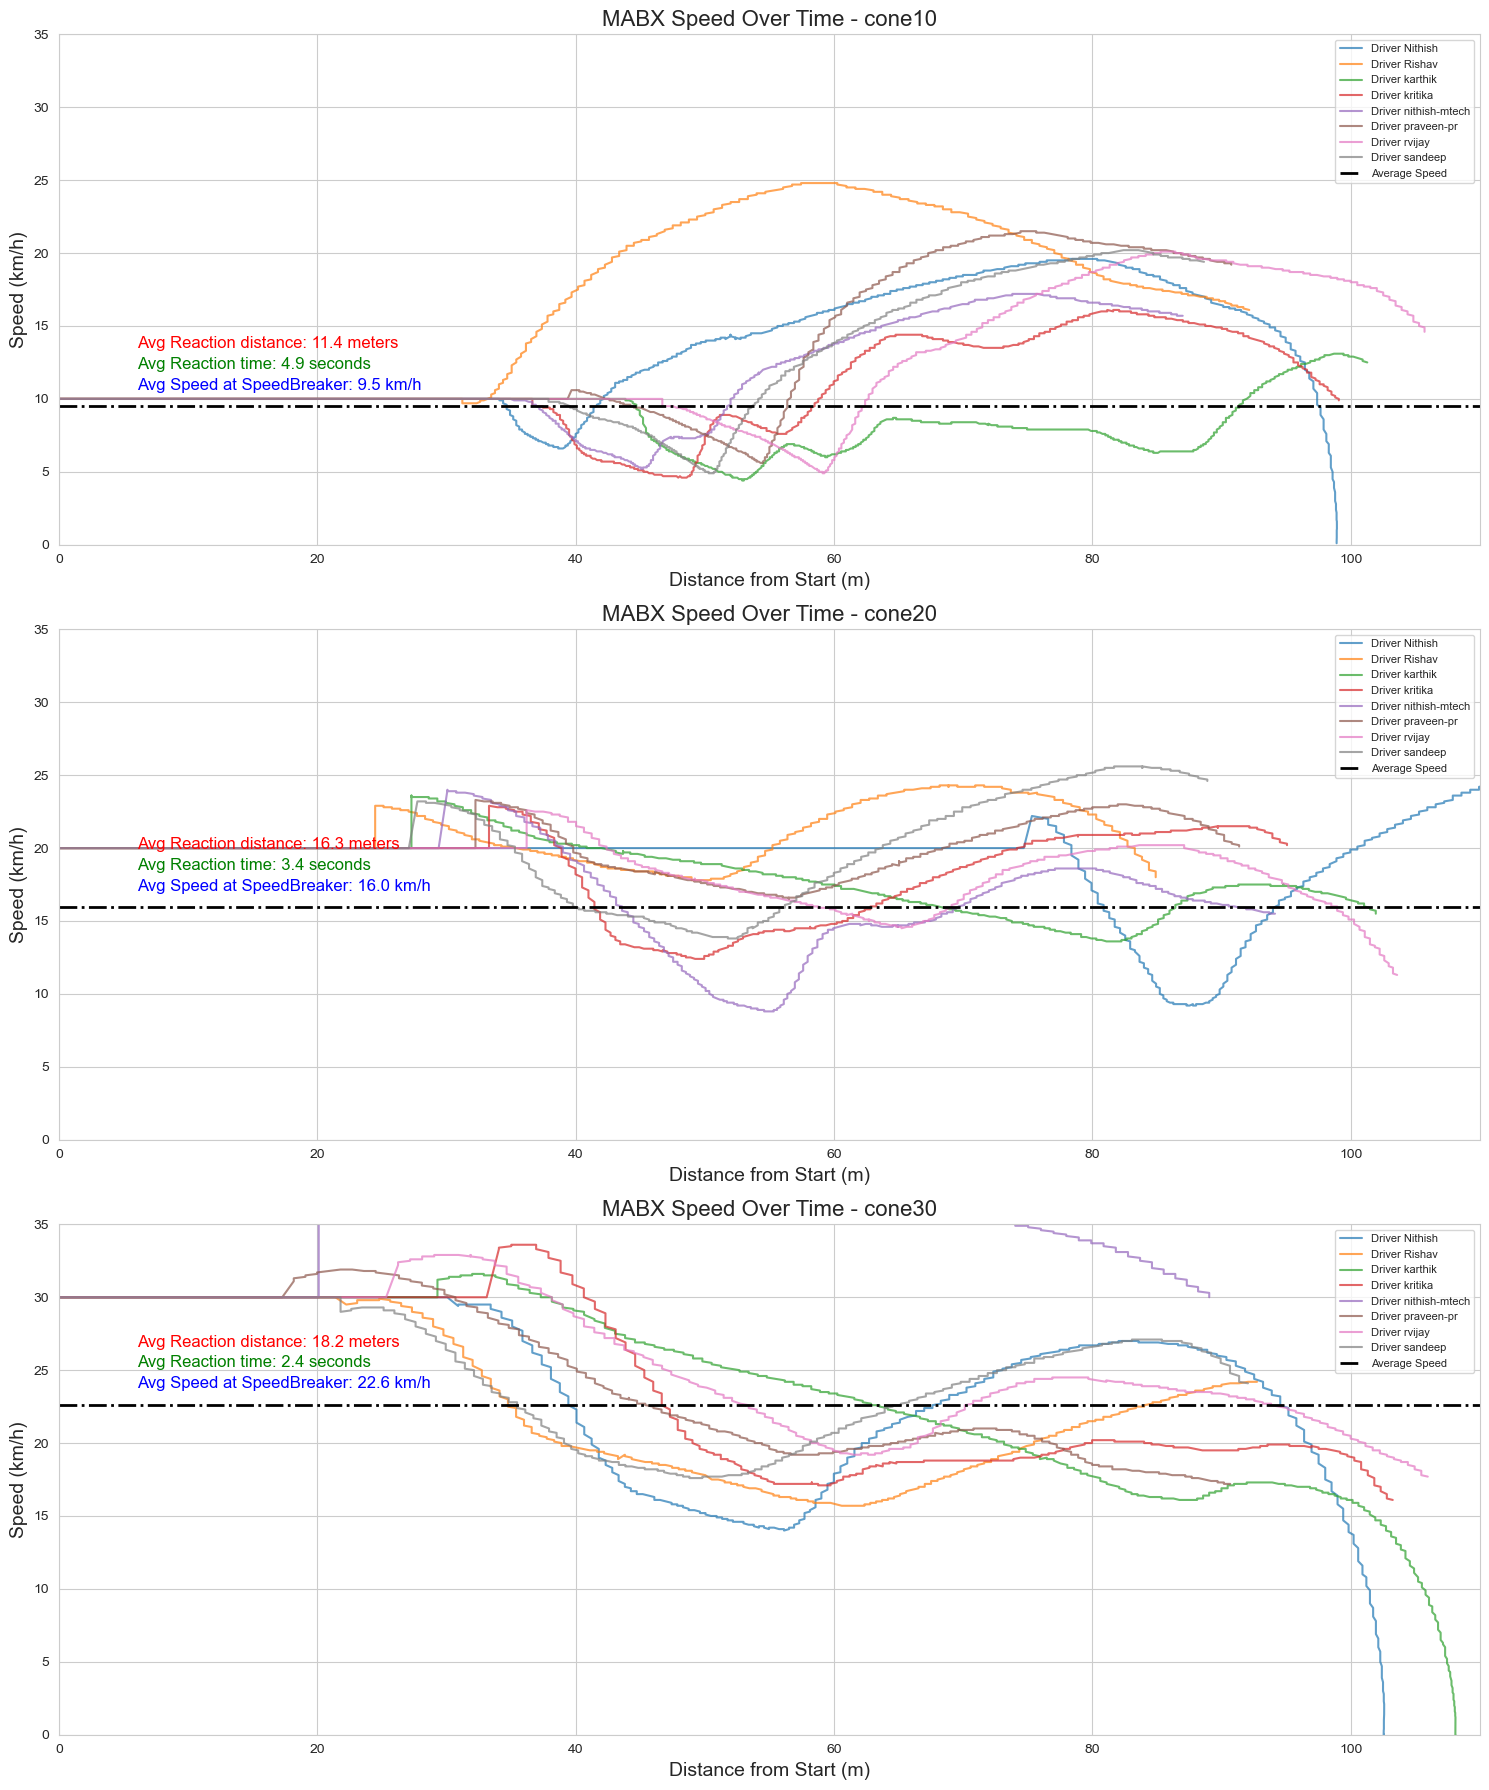

In [279]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style
sns.set_style("whitegrid")

# Determine the number of users and datasets
num_users = len(data)
num_datasets = len(next(iter(data.values())))

# Create a figure with 3 subplots (one for each dataset)
fig, axs = plt.subplots(num_datasets, 1, figsize=(15, 6 * num_datasets))

# Use a colormap for user differentiation
cmap = plt.get_cmap('tab10')

for i, (df_name, df) in enumerate(next(iter(data.values())).items()):  # Iterate over datasets
    for j, (user_name, user_data) in enumerate(data.items()):  # Iterate over users
        user_df = user_data[df_name]  # Get the specific dataset for the current user

        # Plot all users' data on the same subplot for the current dataset
        axs[i].plot(user_df['dist_from_start'], user_df['Veh_MABX_Speed'], label=f'Driver {user_name}', color=cmap(j % 10), alpha=0.7)

    if 'cone10' in df_name:
        axs[i].axhline(y=mean_speed['cone10'], color='black', linestyle='-.', label='Average Speed', linewidth=2)
        avg_x_value_speed = mean_speed['cone10']
        avg_reacton_time = mean_time['cone10']
        avg_reaction_distance = reaction_distance['cone10']
    elif 'cone20' in df_name:
        axs[i].axhline(y=mean_speed['cone20'], color='black', linestyle='-.', label='Average Speed', linewidth=2)
        avg_x_value_speed = mean_speed['cone20']
        avg_reacton_time = mean_time['cone20']
        avg_reaction_distance = reaction_distance['cone20']
    elif 'cone30' in df_name:
        axs[i].axhline(y=mean_speed['cone30'], color='black', linestyle='-.', label='Average Speed', linewidth=2)
        avg_x_value_speed = mean_speed['cone30']
        avg_reacton_time = mean_time['cone30']
        avg_reaction_distance = reaction_distance['cone30']

    # Draw a vertical line at x_value and annotate it with the average speed at that point
    # axs[i].axvline(x=x_value, color='r', linestyle='--', label='Speed-Breaker Position')
    axs[i].annotate(f'Avg Speed at SpeedBreaker: {avg_x_value_speed:.1f} km/h', (5, avg_x_value_speed), xytext=(10, 15),
                    textcoords='offset points', va='center', ha='left', fontsize=12, color='blue')
    axs[i].annotate(f'Avg Reaction time: {avg_reacton_time:.1f} seconds', (5, avg_x_value_speed), xytext=(10, 30),
                    textcoords='offset points', va='center', ha='left', fontsize=12, color='green')
    axs[i].annotate(f'Avg Reaction distance: {avg_reaction_distance:.1f} meters', (5, avg_x_value_speed), xytext=(10, 45),
                    textcoords='offset points', va='center', ha='left', fontsize=12, color='red')

    axs[i].set_xlabel('Distance from Start (m)', fontsize=14)
    axs[i].set_ylabel('Speed (km/h)', fontsize=14)
    axs[i].set_title(f'MABX Speed Over Time - {df_name}', fontsize=16)
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].grid(True)
    axs[i].set_xlim(0, 110)
    axs[i].set_ylim(0, 35)

plt.tight_layout()
plt.show()


#### Moving Average

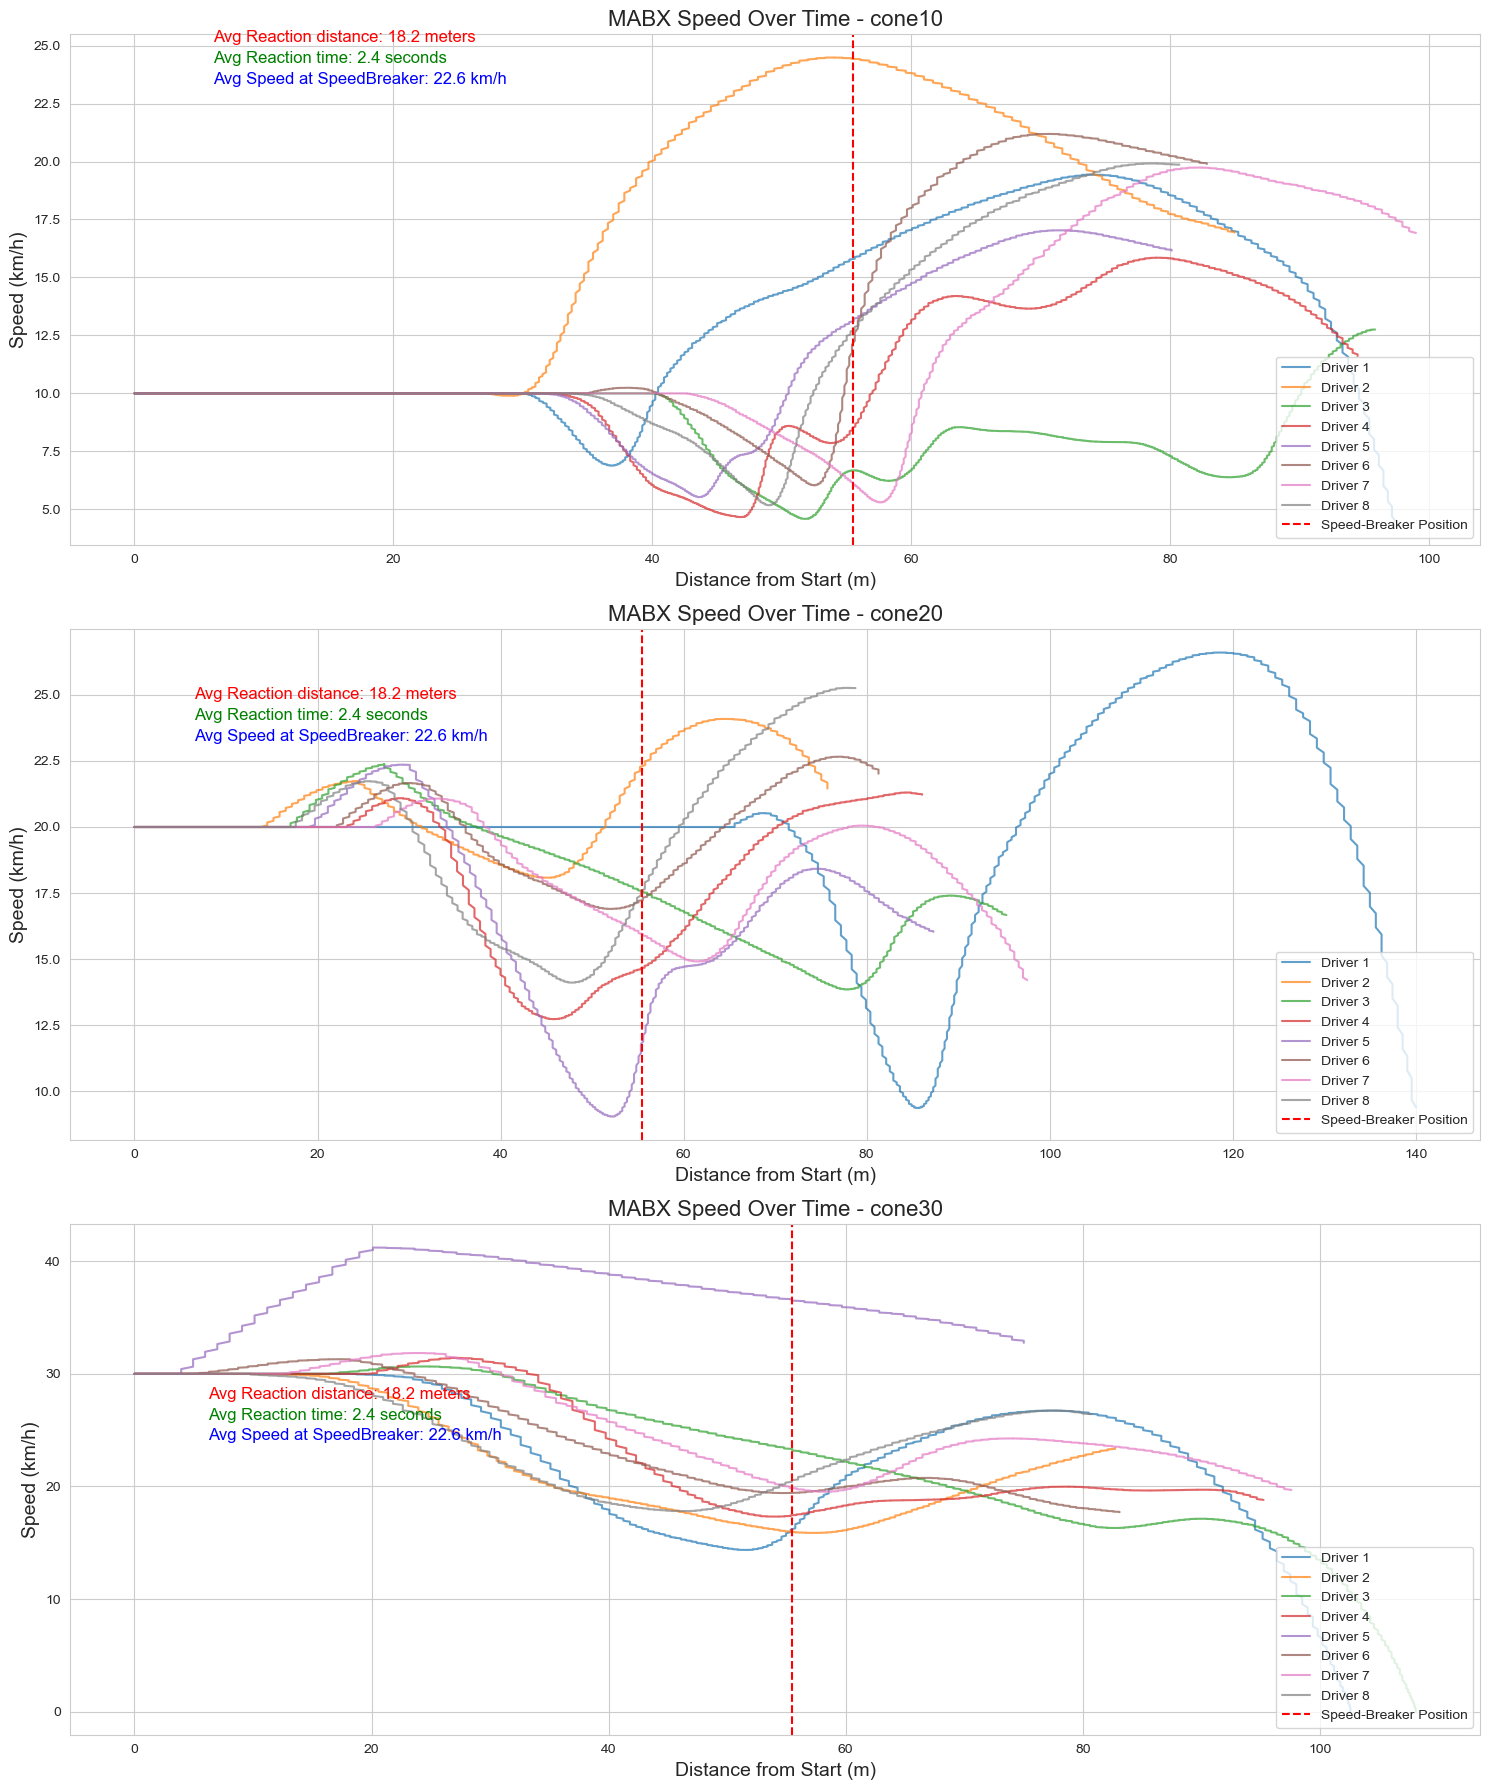

In [280]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style
sns.set_style("whitegrid")

# Determine the number of users and datasets
num_users = len(data)
num_datasets = len(next(iter(data.values())))

# Create a figure with 3 subplots (one for each dataset)
fig, axs = plt.subplots(num_datasets, 1, figsize=(15, 6 * num_datasets))

# Use a colormap for user differentiation
cmap = plt.get_cmap('tab10')

# Define a moving average function
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

window_size = 50  # or any other size depending on your data

for i, (df_name, df) in enumerate(next(iter(data.values())).items()):  # Iterate over datasets
    # List to store all speeds for the current dataset
    all_speeds = []
    # List to store speeds at x_value for all users
    speedbreaker_speeds = []

    for j, (user_name, user_data) in enumerate(data.items()):  # Iterate over users
        user_df = user_data[df_name]  # Get the specific dataset for the current user

        x_value = 55.5  

        # Add all speeds to the list
        all_speeds.extend(user_df['Veh_MABX_Speed'].tolist())


        # Apply moving average to the speed data
        smoothed_speed = moving_average(user_df['Veh_MABX_Speed'].values, window_size)

        # Plot all users' data on the same subplot for the current dataset
        axs[i].plot(user_df['dist_from_start'][:-window_size+1], smoothed_speed, label=f'Driver {j+1}', color=cmap(j % 10), alpha=0.7)

    if 'auto10' in df_name:
        axs[i].axhline(y=mean_speed['auto10'], color='black', linestyle='-.', label='Average Speed', linewidth=2)
        avg_x_value_speed = mean_speed['auto10']
        avg_reacton_time = mean_time['auto10']
        avg_reaction_distance = reaction_distance['auto10']
    elif 'auto20' in df_name:
        axs[i].axhline(y=mean_speed['auto20'], color='black', linestyle='-.', label='Average Speed', linewidth=2)
        avg_x_value_speed = mean_speed['auto20']
        avg_reacton_time = mean_time['auto20']
        avg_reaction_distance = reaction_distance['auto20']
    elif 'auto30' in df_name:
        axs[i].axhline(y=mean_speed['auto30'], color='black', linestyle='-.', label='Average Speed', linewidth=2)
        avg_x_value_speed = mean_speed['auto30']
        avg_reacton_time = mean_time['auto30']
        avg_reaction_distance = reaction_distance['auto30']

    # Draw a vertical line at x_value and annotate it with the average speed at that point
    axs[i].axvline(x=x_value, color='r', linestyle='--', label='Speed-Breaker Position')
    axs[i].annotate(f'Avg Speed at SpeedBreaker: {avg_x_value_speed:.1f} km/h', (5, avg_x_value_speed), xytext=(10, 15),
                    textcoords='offset points', va='center', ha='left', fontsize=12, color='blue')
    axs[i].annotate(f'Avg Reaction time: {avg_reacton_time:.1f} seconds', (5, avg_x_value_speed), xytext=(10, 30),
                    textcoords='offset points', va='center', ha='left', fontsize=12, color='green')
    axs[i].annotate(f'Avg Reaction distance: {avg_reaction_distance:.1f} meters', (5, avg_x_value_speed), xytext=(10, 45),
                    textcoords='offset points', va='center', ha='left', fontsize=12, color='red')

    axs[i].set_xlabel('Distance from Start (m)', fontsize=14)
    axs[i].set_ylabel('Speed (km/h)', fontsize=14)
    axs[i].set_title(f'MABX Speed Over Time - {df_name}', fontsize=16)
    axs[i].legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

In [281]:
df_cone20 = data['Aravind']['cone30']

# Select only the 'latitude' and 'Longitude' columns
lat_lng_data = df_cone20[['Lat', 'Lng']]

# Export to CSV
lat_lng_data.to_csv('plot.csv', index=False)

KeyError: 'Aravind'

In [ ]:
import plotly.express as px
import pandas as pd

# Import data from USGS
data1 = pd.read_csv('/home/ninerishav/TiHANLab-Codes/Solio-Suzuki/navigation/SingletonCodes/autonomous-mode/plot.csv')

# Create scatter map
fig = px.scatter_geo(data1, 
                     lat='Lat', 
                     lon='Lng', 
                     scope='asia', 
                     title='Pothole Location', 
                     projection='natural earth', 
                     color_discrete_sequence=['blue'], 
                     width=1200, 
                     height=800, 
                     opacity=0.5, 
                     labels={'latitude': 'Latitude', 'longitude': 'Longitude'}, 
                     template='plotly_dark', 
)
# add one point to the scatter plot
pothole_lat = 17.602129066824
pothole_lon = 78.126623770904

# fig.add_trace(
#     px.scatter_geo(lat=[pothole_lat], lon=[pothole_lon], color_discrete_sequence=['red'], width=1200, height=800, title='Pothole Location').data[0]
# )

fig.update_layout(title_text='Pothole Data collection', xaxis_title='Longitude', yaxis_title='Latitude')
fig.show()


FileNotFoundError: [Errno 2] No such file or directory: '/home/ninerishav/TiHANLab-Codes/Solio-Suzuki/navigation/SingletonCodes/autonomous-mode/plot.csv'

In [ ]:
import plotly.io as pio
pio.write_html(fig, file='pothole.html', auto_open=False)

In [ ]:
# ######## Not using anymore
# # Set seaborn style
# sns.set(style="darkgrid")

# # Create a figure with 3 subplots (one for each dataset)
# fig, axs = plt.subplots(num_datasets, 1, figsize=(5, 15))

# # Use a colormap for user differentiation
# cmap = sns.color_palette("hsv", num_users)

# # given_lat, given_lon = 17.602129066824, 78.126623770904
# given_lat, given_lon = 17.602129204103562, 78.12660004713902
# # lateral_lat, lateral_long = 17.602129024052, 78.126620129781  #santhosh
# lateral_lat, lateral_long = 17.602129066824, 78.126623770904 #shyam

# for i, (df_name, df) in enumerate(data['Nithish'].items()):
#     axs[i].scatter(df['Lng'], df['Lat'], label=f'Speed {(i+1*10)}', color=cmap[i+1 % 10], alpha=0.09, s=50)
    
#     # Highlight the given point
#     axs[i].scatter(given_lon, given_lat, color='red', alpha=1.0, s=100)
#     axs[i].scatter(lateral_long, lateral_lat, color='blue', alpha=1.0, s=100)
    
#     axs[i].set_xlabel('Longitude', fontsize=14)
#     axs[i].set_ylabel('Latitude', fontsize=14)
#     axs[i].set_title(f'GPS Location - {df_name}', fontsize=16, color='white')
#     axs[i].legend(loc='upper left', fontsize=10)
#     axs[i].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# plt.tight_layout()
# plt.show()

### lateral Distance 


lateral distance dx is calculated from the (lat,long points of pothole distance location) 17°36'07.5"N 78°07'35.9"E  to the (min negative value of tyre_angle ) where the vehcile is straight to the lat, long co-ordinates of the pothole location 

#### Nitish Code

In [ ]:
import numpy as np

# Function to convert lat/long in degrees to radians
def degrees_to_radians(degrees):
    return np.pi * degrees / 180.0

# Function to calculate the lateral distance `dx`
def calculate_lateral_distance(lat1, lon1, lat2, lon2, bearing=None):
    # Convert latitudes and longitudes from degrees to radians
    lat1, lon1, lat2, lon2 = map(degrees_to_radians, [lat1, lon1, lat2, lon2])
    
    # Calculate differences
    dlon = lon2 - lon1
    
    # Calculate bearing if not provided
    if bearing is None:
        y = np.sin(dlon) * np.cos(lat2)
        x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
        bearing = np.arctan2(y, x)
    
    # Calculate lateral distance 'dx'
    dx = np.arcsin(np.sin(dlon) * np.cos(lat2) / np.sin(bearing)) * 6371 * 1000  # Earth radius in meters
    return dx


pothole_lat = 17.602129066824
pothole_lon = 78.126623770904

# Assuming 'data' is a dictionary with driver names as keys and their data as values
# Each value is another dictionary with keys 'cone10', 'cone20', 'cone30' and their respective DataFrame

# Initialize a dictionary to hold the lateral distances for all drivers and datasets
dx_distances = {}

# Iterate over each dataset for each driver
for dataset in ['cone10', 'cone20', 'cone30']:
    dx_distances[dataset] = {}
    for driver_name, driver_datasets in data.items():
        driver_df = driver_datasets[dataset]
        # Find the index of the first minimum negative tire angle (assumed pothole avoidance start)
        min_neg_tire_angle_index = driver_df['Tire_Angle'].idxmin()
        # Get the vehicle's lat and lon at this index
        vehicle_lat = driver_df.loc[min_neg_tire_angle_index, 'Lat']
        vehicle_lon = driver_df.loc[min_neg_tire_angle_index, 'Lng']
        # Calculate lateral distance 'dx'
        dx = calculate_lateral_distance(pothole_lat, pothole_lon, vehicle_lat, vehicle_lon)
        # Store the `dx` in the dictionary under the current dataset and driver
        dx_distances[dataset][driver_name] = dx

# Print out the lateral distances 'dx' for all drivers in each dataset
# for dataset, distances in dx_distances.items():
#     print(f"\n{dataset} Lateral Distances:")
#     for driver, distance in distances.items():
#         print(f"Driver {driver}: {distance:.2f} meters")

# Calculate the mean lateral distance for each dataset
mean_lateral_distances = {dataset: np.nanmean(list(distances.values())) for dataset, distances in dx_distances.items()}
mean_lateral_distances


{'cone10': 7.796154352201321,
 'cone20': 9.064527116504314,
 'cone30': 11.183452371571043}

#### Rishav

In [ ]:
import numpy as np

# Function to calculate the lateral distance `dx`
def calculate_lateral_distance(lat1, lon1, lat2, lon2, bearing=None):
    # Convert latitudes and longitudes from degrees to radians
    lat1, lon1, lat2, lon2 = map(degrees_to_radians, [lat1, lon1, lat2, lon2])
    
    # Calculate differences
    dlon = lon2 - lon1
    
    # Calculate bearing if not provided
    if bearing is None:
        y = np.sin(dlon) * np.cos(lat2)
        x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
        bearing = np.arctan2(y, x)
    
    # Calculate lateral distance 'dx'
    dx = np.arcsin(np.sin(dlon) * np.cos(lat2) / np.sin(bearing)) * 6371 * 1000  # Earth radius in meters
    return dx

pothole_lat = 17.602129066824
pothole_lon = 78.126623770904

lat_lng = {}
dx_distances

# Iterate over each dataset for each driver
for dataset in ['cone10', 'cone20', 'cone30']:
    lat_lng[dataset] = {}
    for driver_name, driver_datasets in data.items():
        driver_df = driver_datasets[dataset]
        selected_data = data[driver_name][dataset].iloc[ending_point[driver_name][dataset]]
        vehicle_lat, vehicle_lon = selected_data['Lat'], selected_data['Lng']
        # Store the 'Lat' and 'Lng' in the dictionary under the current dataset and driver
        lat_lng[dataset][driver_name] = (vehicle_lat, vehicle_lon)

        dx = calculate_lateral_distance(pothole_lat, pothole_lon, vehicle_lat, vehicle_lon)
        # Store the `dx` in the dictionary under the current dataset and driver
        dx_distances[dataset][driver_name] = dx

# Print out the latitudes and longitudes for all drivers in each dataset
# for dataset, lat_lngs in lat_lng.items():
#     print(f"\n{dataset} Latitudes and Longitudes:")
#     for driver, (lat, lng) in lat_lngs.items():
#         print(f"Driver {driver}: Latitude = {lat}, Longitude = {lng}")

# Print out the lateral distances 'dx' for all drivers in each dataset
for dataset, distances in dx_distances.items():
    print(f"\n{dataset} Lateral Distances:")
    for driver, distance in distances.items():
        print(f"Driver {driver}: {distance:.2f} meters")

# filter values larger than 5
dx_distances_filtered = {dataset: {driver: distance for driver, distance in distances.items() if distance < 3.5} for dataset, distances in dx_distances.items()}

# Calculate the mean lateral distance for each dataset
mean_lateral_distances_filtered = {dataset: np.nanmean(list(distances.values())) for dataset, distances in dx_distances_filtered.items()}
mean_lateral_distances_filtered



cone10 Lateral Distances:
Driver ANchary: 2.10 meters
Driver Abhisek: 0.60 meters
Driver Jaisingh: 0.69 meters
Driver Rahul: 1.19 meters
Driver Sai: 0.83 meters
Driver Santhosh: 0.39 meters
Driver Shyam: 0.38 meters
Driver mahender: 4.58 meters
Driver munawar: 2.98 meters
Driver r-mahender: 1.02 meters
Driver r-rahul: 0.95 meters
Driver raghuvamsi: 0.92 meters
Driver raviprasad: 0.21 meters
Driver venu: 0.15 meters
Driver vijay-chand: 2.14 meters

cone20 Lateral Distances:
Driver ANchary: 1.11 meters
Driver Abhisek: 11.15 meters
Driver Jaisingh: 0.84 meters
Driver Rahul: 0.46 meters
Driver Sai: 2.33 meters
Driver Santhosh: 0.67 meters
Driver Shyam: 1.00 meters
Driver mahender: 3.07 meters
Driver munawar: 2.26 meters
Driver r-mahender: 1.63 meters
Driver r-rahul: 2.61 meters
Driver raghuvamsi: 2.27 meters
Driver raviprasad: 0.86 meters
Driver venu: 1.44 meters
Driver vijay-chand: 1.65 meters

cone30 Lateral Distances:
Driver ANchary: 5.68 meters
Driver Abhisek: 6.42 meters
Driver Jaisi

{'cone10': 1.0394917707489781,
 'cone20': 1.5850925326007084,
 'cone30': 1.708717869294167}

In [ ]:
# Convert the mean lateral distances from meters to centimeters
mean_lateral_distances_cm = {dataset: distance * 100 for dataset, distance in mean_lateral_distances_filtered.items()}

# subtract 80 cm from the mean lateral distance
mean_lateral_distances_cm['cone10'] -= 80
mean_lateral_distances_cm['cone20'] -= 80
mean_lateral_distances_cm['cone30'] -= 80

mean_lateral_distances_cm

{'cone10': 47.533406966341616,
 'cone20': 78.50925326007084,
 'cone30': 133.65204768835792}

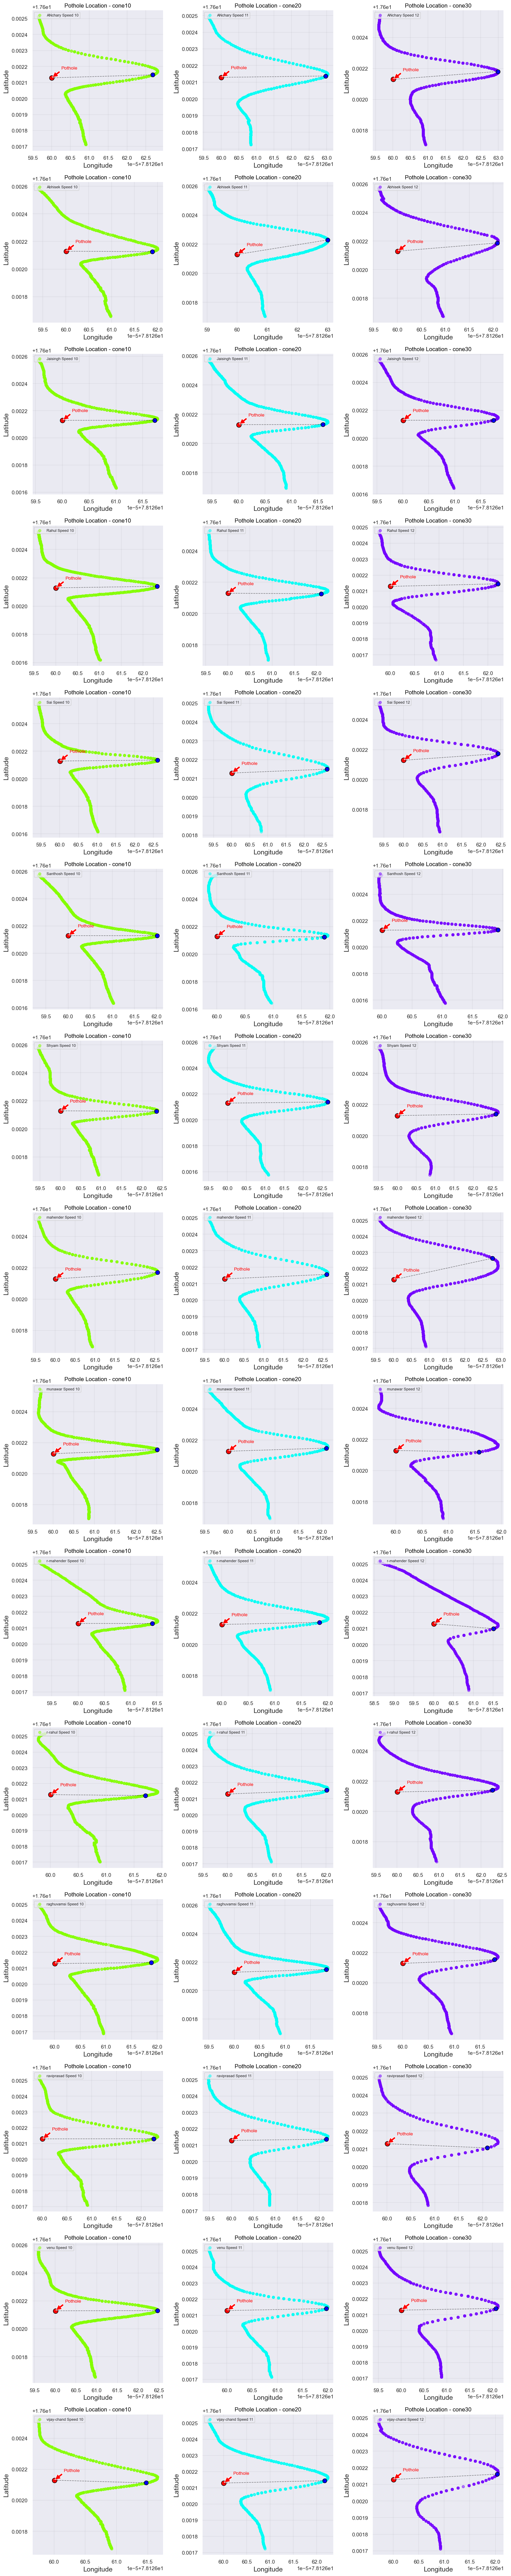

In [ ]:
# Set seaborn style
sns.set(style="darkgrid")

# Create a figure with subplots for each driver and each dataset
fig, axs = plt.subplots(num_users, num_datasets, figsize=(15, 5*num_users))

# Use a colormap for user differentiation
cmap = sns.color_palette("hsv", num_datasets)

given_lat, given_lon = 17.602129204103562, 78.12660004713902

for j, (driver_name, driver_data) in enumerate(data.items()):
    for i, (df_name, df) in enumerate(driver_data.items()):
        # Get lateral_lat, lateral_long from lat_lng for each dataset and driver
        selected_data = df.iloc[ending_point[driver_name][df_name]]
        lateral_lat, lateral_long = selected_data['Lat'], selected_data['Lng']
        
        # Scatter plot with transparency and size adjustments for better visibility
        axs[j, i].scatter(df['Lng'], df['Lat'], label=f'{driver_name} Speed {(i+1*10)}', color=cmap[i], alpha=0.5, s=30)
        
        # Highlight the given point and lateral point with different colors and sizes
        axs[j, i].scatter(given_lon, given_lat, color='red', alpha=1.0, s=100, edgecolors='black', linewidths=1)
        axs[j, i].scatter(lateral_long, lateral_lat, color='blue', alpha=1.0, s=75, edgecolors='black', linewidths=1)
        
        axs[j, i].set_xlabel('Longitude', fontsize=14)
        axs[j, i].set_ylabel('Latitude', fontsize=14)
        axs[j, i].set_title(f'Pothole Location - {df_name}', fontsize=12, color='black')
        axs[j, i].legend(loc='upper left', fontsize=8)
        axs[j, i].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
        
        # Annotate the pothole with a red arrow for better visibility
        axs[j, i].annotate('Pothole', (given_lon, given_lat), xytext=(20, 20),
                    textcoords='offset points', va='center', ha='left', fontsize=10, color='red',
                    arrowprops=dict(facecolor='red', shrink=0.05))
        
        # Draw a line between pothole and lateral point with a thicker line for better visibility
        axs[j, i].plot([given_lon, lateral_long], [given_lat, lateral_lat], color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()